### Working with Electronic Medical Records (EMR)

##### Author: Cornelia Ilin
##### Date: Oct 20, 2021
##### Class: Clustering analysis, W207 - MIDS program

### Step 1: Import libraries

In [1]:
import os
from IPython.display import Image

# standard
import numpy as np
import pandas as pd

# sklearn
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# distances
from scipy.spatial.distance import pdist, squareform

# data visualization
from matplotlib import cm
import matplotlib.pyplot as plt
from IPython.display import Image

# others
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import set_link_color_palette
from scipy.cluster.hierarchy import linkage

### Step 2: Define working directories

In [2]:
in_dir_data = '/home/cilin/assign2/mimic_database/'
in_dir_images = '/home/cilin/assign2/images/'

### Step 3: Define functions

### Step 4: Read data

---
### Data overview 

[Source: https://physionet.org/content/mimiciii/1.4/]

---

Electronic Medical Records = contain patient medical and treatment history in electronic form. See an example below. 

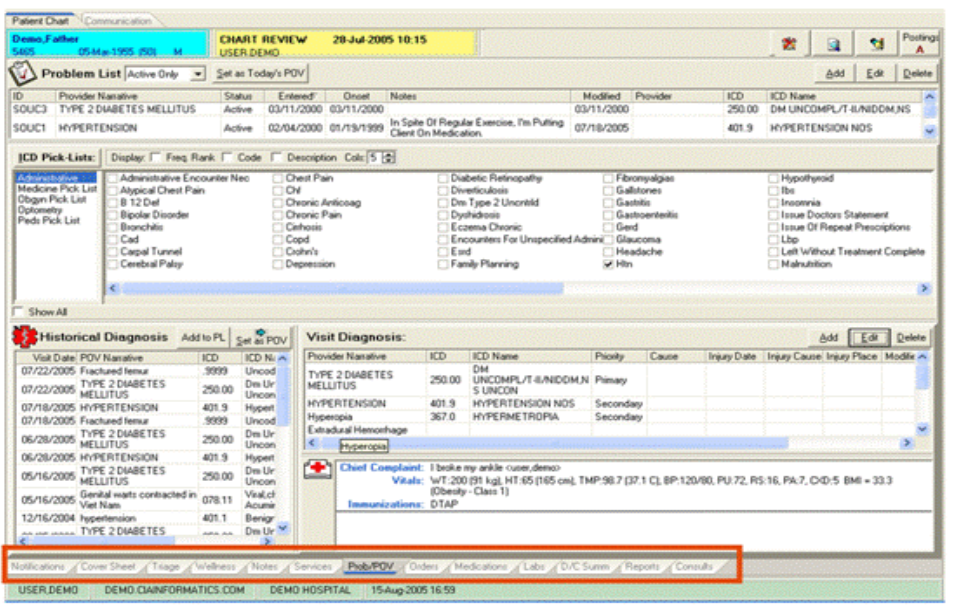

In [3]:
# Image source: https://uxpajournal.org/usability-of-electronic-medical-records/, accessed Oct 21, 2021
Image(filename=in_dir_images+'EMR.png', width=500)

We will be working with the MIMIC-III Clinical Database, a large, freely-available database (but you need to apply for permision to use it, see here for more info: https://physionet.org/content/mimiciii/1.4/).

**Content**: health-related data associated with over 40,000 patients who stayed in critical care units

**Location**: Beth Israel Deaconess Medical Center (a hospital in Boston, Massachusetts)

**Time period**: 2001 and 2012. 

**Main variables**: patient demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (including post-hospital discharge).

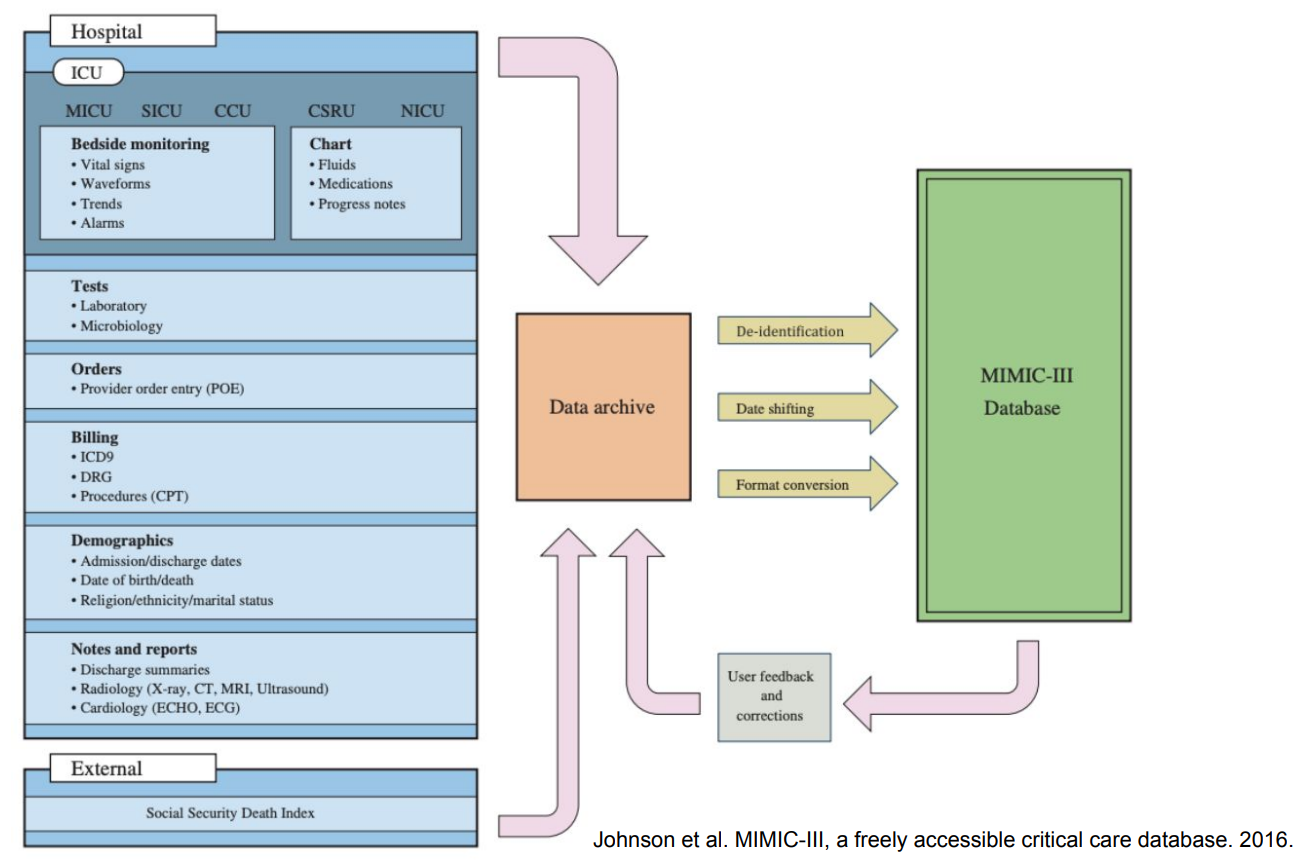

In [4]:
# Image source: Lecture 6, BIODS 220: AI in Healthcare, accessed Oct 21, 2021
Image(filename=in_dir_images+'EMR2.png', width=600)

---
### Motivation
[Source: https://physionet.org/content/mimiciii/1.4/]

---

High interest in the adoption of **digital health record systems in hospitals**. The movement started in 1960s. 

Some statistics: The number of US non-federal acute care hospitals with basic digital systems increased from 9.4 to 75.5% between 2008 and 2014.

Hospital data offers lots of potential in terms of understanding and improving care. But there is still lots of work to be done to make this possible. For example, one challenge is to integrate data across different digital health record systems.

ML/AI: hot topic in the healthcare community.

---
### Types of EMR data
---

Electronical Medical Records (EMR) contain two types of data: structured (e.g., LDL level values etc) and unstructured (e.g., clinican notes, images, etc)

Let's start by printing the datasets that are available in MIMIC-III

In [5]:
for file in os.listdir('/home/cilin/assign2/mimic_database/'):
    print(file)

NOTEEVENTS.csv
LABEVENTS.csv
D_ITEMS.csv
TRANSFERS.csv
CHARTEVENTS.csv
mapped_elements
PRESCRIPTIONS_reduced.csv
DRGCODES.csv
SERVICES.csv
PATIENTS.csv
PRESCRIPTIONS_reduced_byday.csv
D_LABITEMS.csv
CPTEVENTS.csv
INPUTEVENTS_CV.csv
D_ICD_DIAGNOSES.csv
ICUSTAYS.csv
CALLOUT.csv
D_CPT.csv
DATETIMEEVENTS.csv
DIAGNOSES_ICD.csv
PRESCRIPTIONS.csv
ADMISSIONS.csv
OUTPUTEVENTS.csv
CAREGIVERS.csv
MICROBIOLOGYEVENTS.csv
PROCEDURES_ICD.csv
PROCEDUREEVENTS_MV.csv
INPUTEVENTS_MV.csv
D_ICD_PROCEDURES.csv


And now let's look at an example of **structured data**


In [6]:
# read admissions dataset
df1 = pd.read_csv(
    in_dir_data + 'PATIENTS.csv'
)
df1.head(5)

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


print some patient stats

In [7]:
print(
    'The number of total patients:',
     df1.SUBJECT_ID.nunique(),
    '\n'
)

print(
    'The counts of female patients:',
     df1[df1.GENDER.eq('F')].GENDER.count(),
    '\n',
    'The counts of male patients:',
     df1[df1.GENDER.eq('M')].GENDER.count(),    
    '\n'
)
      

The number of total patients: 46520 

The counts of female patients: 20399 
 The counts of male patients: 26121 



In [8]:
# read admissions dataset
df2 = pd.read_csv(
    in_dir_data + 'ADMISSIONS.csv',
    nrows=100
)
df2.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [9]:
# read lab events dataset
df3 = pd.read_csv(
    in_dir_data + 'LABEVENTS.csv',
    nrows=100
)
df3.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal


And finally, let's look at an example of **unstructured data**

In [10]:
# read note events dataset
df4 = pd.read_csv(
    in_dir_data + 'NOTEEVENTS.csv',
    nrows=100
)
df4.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


And we can pay more attention to the TEXT column:

In [11]:
print (
    "Printing clinican notes for patient ID:",
    df4.SUBJECT_ID[0],
    '\n----------------------------------------------'
)
df4.TEXT[0]

Printing clinican notes for patient ID: 22532 
----------------------------------------------


'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

---
### Merge datasets together
---

I already run some code that merges these datasets [credit: BIODS220, Stanford University], so today we will work with a "relatively" clean version of the data.

In this data, each measurement is assigned to a single 24hr block (like 2117-09-11), rather than a specific timestamp (like 2117-09-11 16:04:00). 

In [12]:
df = pd.read_csv(
    in_dir_data +
    '/mapped_elements/CHARTEVENTS_reduced_24_hour_blocks_plus_admissions_plus_patients_plus_scripts_plus_icds_plus_notes.csv'
)

columns = [col for col in df.columns if col in(('SUBJECT_ID', 'DOB','ADMITYEAR','AGE'))] + \
            [col for col in df.columns if not col.startswith(('SUBJECT_ID', 'DOB','ADMITYEAR','AGE'))]
df = df[columns]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (151,153) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
print(
    'Number of rows:', df.shape[0],
    '\nNumber of columns:', df.shape[1]
)

Number of rows: 589410 
Number of columns: 236


Let's look at one individual

In [14]:
#df[df.SUBJECT_ID.eq(58526.0)]

print columns

In [15]:
[col for col in df.columns]

['SUBJECT_ID',
 'DOB',
 'ADMITYEAR',
 'AGE',
 'BUN',
 'HDL',
 'INR',
 'Inspired O2 Fraction',
 'LDL',
 'PEEP Set',
 'PT',
 'PTT',
 'RBCs',
 'WBCs',
 'anion gap',
 'atypical lymphocytes',
 'bands',
 'basophils',
 'central venous pressure',
 'chloride',
 'creatinine',
 'daily weight',
 'diastolic',
 'eosinophils',
 'glucose',
 'heart rate',
 'hemocrit',
 'hemoglobin',
 'lymphocytes',
 'monocytes',
 'neutrophils',
 'platelets',
 'polymorphonuclear leukocytes',
 'potassium_x',
 'pulse oximetry',
 'respiratory rate',
 'sodium',
 'systolic',
 'temperature (F)',
 'tidal volume',
 'triglycerides',
 'troponin',
 'BUN_std',
 'HDL_std',
 'INR_std',
 'Inspired O2 Fraction_std',
 'LDL_std',
 'PEEP Set_std',
 'PT_std',
 'PTT_std',
 'RBCs_std',
 'WBCs_std',
 'anion gap_std',
 'atypical lymphocytes_std',
 'bands_std',
 'basophils_std',
 'central venous pressure_std',
 'chloride_std',
 'creatinine_std',
 'diastolic_std',
 'eosinophils_std',
 'glucose_std',
 'heart rate_std',
 'hemocrit_std',
 'hemoglob

---
### Step 5: Data preprocessing
---

It can take lots of time to run a clustering algorithm on all this data, so next I will do some data preprocessing to help reduce the size of it.

In particular, I would like to focus on patients that are at **risk of sepsis**.

According to the CDC, sepsis is the body's extreme response to an infection. It is a life-threatening medical emergency. Sepsis happens when an infection you already have triggers a chain reaction throughout your body. Infections that lead to sepsis most often start in the lung, urinary tract, skin, or gastrointestinal tract.

In [16]:
def wbc_crit(x):
    if (x > 12 or x < 4) and x != 0:
        return 1
    else:
        return 0

def temp_crit(x):
    if (x > 100.4 or x < 96.8) and x != 0:
        return 1
    else:
        return 0

for target in ['SEPSIS']: ## you can add here more conditions if you would like
    if target == 'SEPSIS':
        df['hr_sepsis'] = df['heart rate'].apply(lambda x: 1 if x > 90 else 0)
        
        df['respiratory rate_sepsis'] = df['respiratory rate'].apply(lambda x: 1 if x>20 else 0)
        
        df['wbc_sepsis'] = df['WBCs'].apply(wbc_crit) 
        
        df['temperature f_sepsis'] = df['temperature (F)'].apply(temp_crit) 
        df['sepsis_points'] = (
                                df['hr_sepsis'] + \
                                df['respiratory rate_sepsis'] + \
                                df['wbc_sepsis'] + df['temperature f_sepsis']
        )
        
        # create target column
        df[target] = (
            (df['sepsis_points'] >= 2) & (df['Infection'] == 1)
        ).apply(lambda x: int(x))
        
        # drop columns
        df.drop(
            columns = [
                'hr_sepsis',
                'respiratory rate_sepsis',
                'wbc_sepsis',
                'temperature f_sepsis',
                'sepsis_points',
                'Infection'
            ],
            inplace=True
        )
        
#keep if sepsis==1
df = df[df.SEPSIS.eq(1)]

In [17]:
print(
    'Number of rows:', df.shape[0],
    '\nNumber of columns:', df.shape[1]
)

Number of rows: 3735 
Number of columns: 236


And finally, just to be able to visualize in a 2D space and to make the computational problem easier, let's focus only on the features **heart rate** and **anion gap**.

The anion gap is a measurement of the difference-or gap-between the negatively charged and positively charged electrolytes. If the anion gap is either too high or too low, it may be a sign of a disorder in your lungs, kidneys, or other organ systems.

The anion gap can be used as a screening tool for elevated lactate in patients with an increased risk of developing sepsis.

In [18]:
X = np.array(df[['heart rate', 'anion gap']])

# standardize data! Hint: see what happends with your cluster predictions if you don't do this
X = StandardScaler().fit_transform(X)

---
### Step 6: Clustering analysis
---

We will start by running a KMeans with 3 clusters

In [19]:
# create an instance of KMeans class using the scikit-learn package
km = KMeans(n_clusters=3,
           init='random',
           #init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=0)

# predict k-means classes
y_km = km.fit_predict(X)

# print cluster predictions
y_km

array([2, 1, 2, ..., 2, 2, 2], dtype=int32)

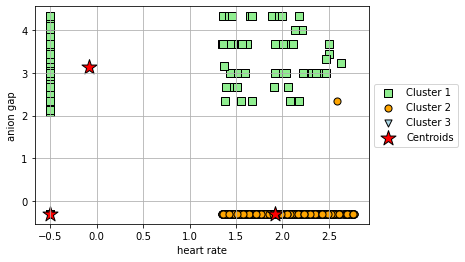

In [20]:
# visualize cluster predictions
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')

plt.xlabel('heart rate')
plt.ylabel('anion gap')

plt.legend(
    scatterpoints=1,
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
plt.grid()

And finally, let's run the DBSCAN algo with an Euclidean metric

In [21]:
# create DBSCAN instance and fit model
db = DBSCAN(eps=0.9, min_samples=10, metric='euclidean')
y_db = db.fit_predict(X)

# print number of clusters identified by DBSCAN
np.unique(db.labels_)

array([0, 1, 2, 3])

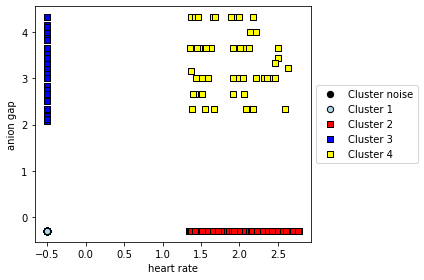

In [22]:
# plot labels
plt.scatter(X[y_db == -1, 0], X[y_db == -1, 1],
            c='black', marker='o', s=40,
            edgecolor='black', 
            label='Cluster noise')

plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='Cluster 1')

plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='Cluster 2')

plt.scatter(X[y_db == 2, 0], X[y_db == 2, 1],
            c='blue', marker='s', s=40,
            edgecolor='black', 
            label='Cluster 3')

plt.scatter(X[y_db == 3, 0], X[y_db == 3, 1],
            c='yellow', marker='s', s=40,
            edgecolor='black', 
            label='Cluster 4')

plt.xlabel('heart rate')
plt.ylabel('anion gap')

plt.legend(
    scatterpoints=1,
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()

In [23]:
pwd

'/home/cilin/assign2'